# to Hive DB

In [ ]:
!pip install seaborn==0.11

In [ ]:
!conda install -c conda-forge imbalanced-learn

In [ ]:
import pandas as pd
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification, make_circles, make_moons, make_blobs
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
ir = 100
n_samples = 10000

def to_hive_safely(df, table):
    df=df.withColumn("idn", F.col("idn").cast("int"))
    df=df.withColumn("label", F.col("label").cast("int"))
    assembler = VectorAssembler(
        inputCols=["feature_1", "feature_2"],
        outputCol="features_no_scale")
    df = assembler.transform(df)
    scaler = StandardScaler(inputCol="features_no_scale", outputCol="features",
                        withStd=True, withMean=True)
    scalerModel = scaler.fit(df)
    scaledData = scalerModel.transform(df)
    scaledData.write.mode("overwrite").saveAsTable(table)


In [ ]:
X,y= make_classification(n_samples = n_samples*10, n_features=2, n_informative= 1, n_redundant=0, n_clusters_per_class= 1,  random_state=10,  class_sep=0.5)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace=True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v1")

In [ ]:
X,y= make_circles(n_samples = n_samples*10,noise=0.05, random_state=42,shuffle=True)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v2")

In [ ]:
X,y= make_moons(n_samples = n_samples*10,noise=0.2, random_state=42, shuffle=True)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v3")

In [ ]:
X,y= make_blobs(n_samples = n_samples*10, random_state=42, shuffle=True, centers=2, cluster_std=3)
X, y = make_imbalance(X, y,sampling_strategy={0: int(n_samples/(ir+1)), 1: int((ir)*(n_samples/(ir+1)))},
                              random_state=42)
data_ir_100 = pd.DataFrame(X, columns = ['feature_1', 'feature_2'])
data_ir_100['label'] = y
data_ir_100.reset_index(inplace=True)
data_ir_100.rename(columns={'index': 'idn'}, inplace = True)
df=spark.createDataFrame(data_ir_100)
to_hive_safely(df, "dummy_data_v4")

# Make comparing plots

In [3]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_context("notebook", font_scale=1.2)

In [44]:
path = pathlib.Path("data/datasetExample") 
results = pd.DataFrame()
ds = []
methods = []
datasets_df = []

for i in path.glob('**/*.csv'):
    partial = pd.read_csv(i.absolute(), header=None)
    partial.columns = ['idn', 'feature_1', 'feature_2', 'label', 'is_selected']
    paths = i.parts[2].split("_")
    datasetid = "_".join(paths[0:3])
    partial['dataset_id'] = datasetid

    if datasetid not in ds:
        print("first datasets")
        datasets_df.append(partial.drop("is_selected", axis = 1))

    partial['ands'] = int(paths[4])
    partial['lsh'] = paths[3]
    if paths[5]=='drop3':
        #method = f"LSH: {paths[3]} with {paths[4]} ANDS, IS: {'_'.join(paths[5:])}"
        partial['is'] = '_'.join(paths[5:])
        method = f"{paths[3]}"
        partial['is_ands'] = f"{'_'.join(paths[5:])}-{paths[4]} ANDS"
    else:
        #method = f"LSH: {paths[3]} with {paths[4]} ANDS, IS: {paths[5]}"
        partial['is'] = paths[5]
        method = f"{paths[3]}"
        partial['is_ands'] = f"{paths[5]}-{paths[4]} ANDS"
    #print(i.absolute(), datasetid, method)
    partial['LSH'] = method
    to_append = [results]       
    to_append.append(partial[partial.is_selected==1].copy().drop("is_selected", axis = 1))
    results = pd.concat(to_append, ignore_index = True)
    ds.append(datasetid)
    methods.append(method)
ds = list(set(ds))
methods = list(set(methods))
total_plots = len(ds)*len(methods)
results= results[results.ands.isin([2,10])].copy().reset_index(drop = True)
datasets_df = pd.concat(datasets_df)
lsh_map = {'hyperplanes': 'RHF', 'projection':'DPF', 'hyperplanes-projection': 'RHF+DPF'}
results.LSH = results.LSH.map(lsh_map)

first datasets
first datasets
first datasets
first datasets


In [45]:
col_order = ["entropy-2 ANDS", "entropy-10 ANDS", ]

## plots based on datasets

In [47]:
def plot_example(ds_p):
    g = sns.FacetGrid(data = results[results.dataset_id==ds_p],
                  hue = 'label', row = 'LSH', col='is_ands',
                  col_order =col_order, row_order = None,
                  margin_titles = True, despine=False, aspect=1.3, height=3.5)
    
    g.map_dataframe(sns.scatterplot,
                x='feature_1', 
                y='feature_2', 
                alpha = 0.8,
                marker = "x",
                palette = 'bright', s=120)
    
    """
    for (col_val, row_val), ax in g.axes_dict.items():
        #print(col_val, row_val)
        ax.set_title(row_val, fontdict = {"fontsize": "xx-large"})
        ax.set_facecolor(face_color[row_val])
        mar_title = [c for c in ax.get_children() if type(c) == matplotlib.text.Annotation]
        mar_title = [c for c in mar_title if "LSH" in c.get_text()]
        if len(mar_title)>0:
            mar_title = mar_title[0] 
            mar_title.set_fontsize("x-large")
            print(mar_title)
    
        sns.scatterplot(data= datasets_df[datasets_df['dataset_id']==ds_p], 
        x = 'feature_1', y = 'feature_2', hue = 'label' , alpha=0.05, ax = ax, legend = False,  marker="+", palette='dark')
    """
    for (col_val, row_val), ax in g.axes_dict.items():
        #print(col_val, row_val)
        d_referece = datasets_df[datasets_df['dataset_id']==ds_p].copy().label.value_counts()
        res = results[(results.dataset_id==ds_p) & (results.LSH==col_val) & (results.is_ands==row_val)].label.value_counts()
        ir_new = res.values[0]/res.values[1]
        ir = d_referece.values[0]/d_referece.values[1]
        diff = (ir-ir_new)/ir*100
        reduction = f"IR {ir_new:0.2F}. IR reduced in {diff:0.2F}%"
        mar_title = [c for c in ax.get_children() if type(c) == matplotlib.text.Annotation]
        mar_title = [c for c in mar_title if "LSH" in c.get_text()]
        xx = ax.get_xlim()
        yy = ax.get_ylim()
        ax.text(xx[1]*0.2, yy[0]*0.7, reduction, fontsize=16,  ha="center", va="center",bbox = {'edgecolor':"black", 'facecolor':"white", 'alpha' : 0.3}) 
            
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.fig.subplots_adjust(wspace=0, hspace=0)
    
    #plt.tight_layout()
    plt.savefig(f'report/{ds_p}.png', dpi = 300)
    print(ds_p, "saved")

dummy_data_v2 saved
dummy_data_v3 saved


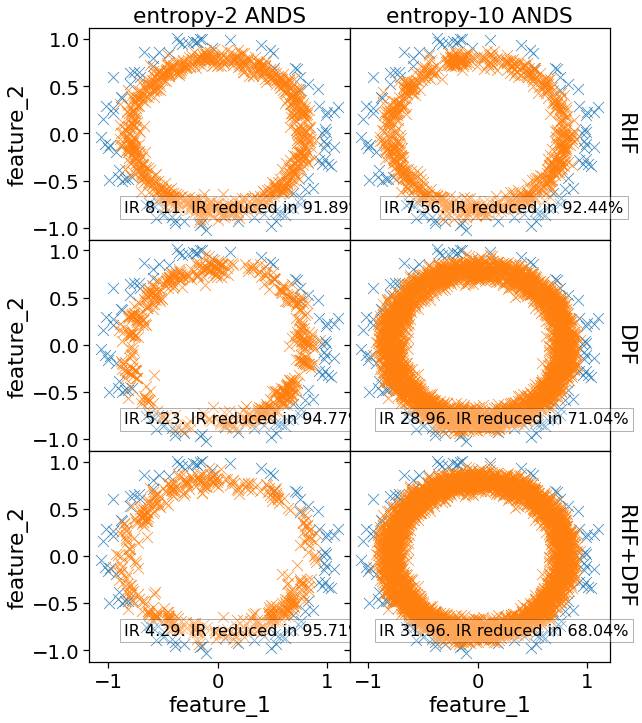

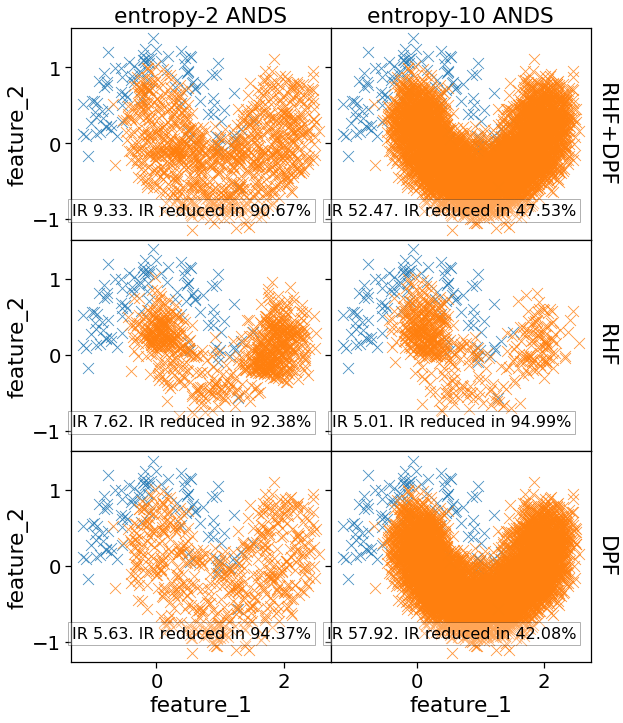

In [48]:
plot_example(ds[ds.index('dummy_data_v2')])
plot_example(ds[ds.index('dummy_data_v3')])

## plots based on methods

In [49]:
def plot_example(ds_p, is_ands, name_file):
    cond_to_plot =  (results.dataset_id.isin(ds_p)) & (results.is_ands.isin(is_ands))
    g = sns.FacetGrid(data = results[cond_to_plot],
                  hue = 'label', row = 'LSH', col='is_ands',
                  col_order = col_order, row_order = None,
                  margin_titles = True, despine=False, aspect=1.3, height=3.5)
    
    g.map_dataframe(sns.scatterplot,
                x='feature_1', 
                y='feature_2', 
                alpha = 0.8,
                marker = "x",
                palette = 'bright', s=120)
    
    ir_df = pd.DataFrame(columns = ['LSH', 'is', 'ir', 'red'])
    idx = 0
    for (col_val, row_val), ax in g.axes_dict.items():
        d_referece = datasets_df[datasets_df['dataset_id']==ds_p[0]].copy().label.value_counts()
        res = results[(results.dataset_id==ds_p[0]) & (results.LSH==col_val) & (results.is_ands==row_val)].label.value_counts()
        ir_new = res.values[0]/res.values[1]
        ir = d_referece.values[0]/d_referece.values[1]

        diff = (ir-ir_new)/ir*100
        reduction = f"IR {ir_new:0.2F}. IR reduced in {diff:0.2F}%"
        reduction = f"IR reduced in {diff:0.2F}%"
        mar_title = [c for c in ax.get_children() if type(c) == matplotlib.text.Annotation]
        mar_title = [c for c in mar_title if "LSH" in c.get_text()]
        xx = ax.get_xlim()
        yy = ax.get_ylim()
        ax.text(xx[1]*0.2, yy[0]*0.7, reduction, fontsize=16,  ha="center", va="center",bbox = {'edgecolor':"black", 'facecolor':"white", 'alpha' : 0.3})
        ir_df.loc[idx, :] =  col_val,row_val,ir_new,diff
        idx+=1
            
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.fig.subplots_adjust(wspace=0, hspace=0)
    
    #plt.tight_layout()
    plt.savefig(f'report/{name_file}.png', dpi = 300)
    print(ds_p, "saved")
    return (ir_df)

In [50]:
sns.set_context("notebook", font_scale=1.8)

In [51]:
face_color = {"entropy-2 ANDS": "1.0", "entropy-10 ANDS": "1.0",
              "drop3_one-2 ANDS": ".9", "drop3_one-10 ANDS":".9",
              "drop3_boundaries-2 ANDS": ".75", "drop3_boundaries-10 ANDS": ".75"}

face_color = {"entropy-2 ANDS": "1.0", "entropy-10 ANDS": "1.0",
              "drop3_one-2 ANDS": "1.0", "drop3_one-10 ANDS":"1.0",
              "drop3_boundaries-2 ANDS": "1.0", "drop3_boundaries-10 ANDS": "1.0"}

['dummy_data_v3'] saved
['dummy_data_v2'] saved


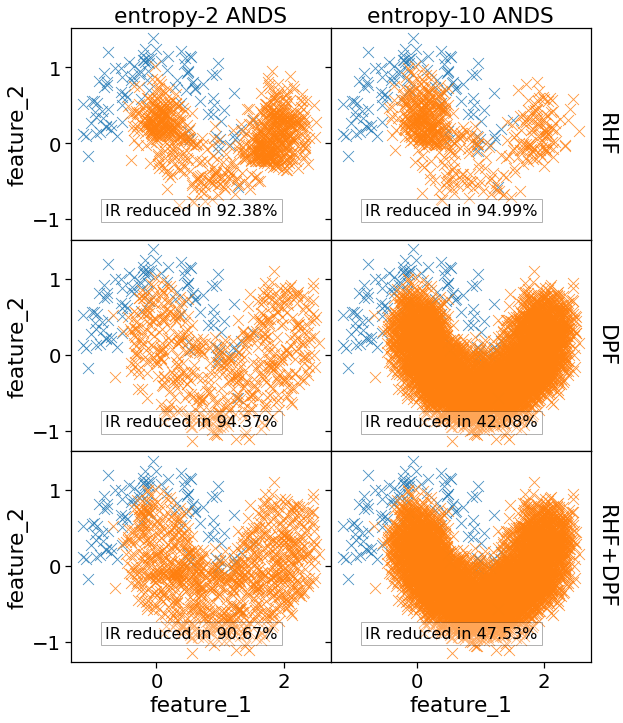

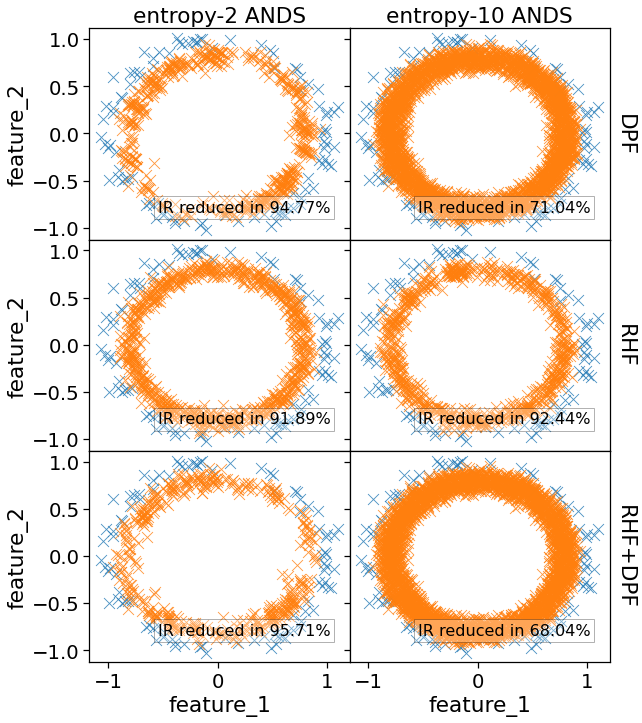

In [52]:
ir_dif_1 = plot_example(['dummy_data_v3'], [c for c in results.is_ands.unique() if 'entropy' in c], 'entropy_1')
ir_dif_2 = plot_example(['dummy_data_v2'], [c for c in results.is_ands.unique() if 'entropy' in c], 'entropy_2')

In [53]:
hue_order = ['RHF', 'DPF', 'RHF+DPF']

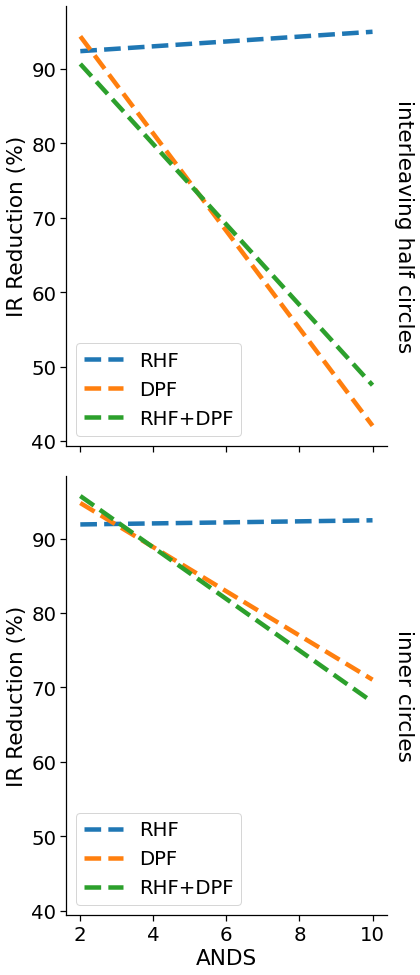

In [54]:
ir_dif_1['dataset'] = 'interleaving half circles'
ir_dif_2['dataset'] = 'inner circles'
ir_df = pd.concat([ir_dif_1,ir_dif_2], ignore_index=True)
ir_df['ANDS'] = ir_df['is'].str.split("-").apply(lambda x : int(x[-1].split("ANDS")[0]))
ir_df['IS'] = ir_df['is'].str.split("-").apply(lambda x : x[0])
ir_df['IR'] = pd.to_numeric(ir_df['ir'])
ir_df['IR Reduction (%)'] = (1 - ir_df['IR']/100.0)*100.0 

sns.color_palette("bright")
#sns.relplot(data = ir_df, x='ANDS', hue= 'method', y = 'IR', kind = 'line', row= 'dataset', aspect=1, height=5)
g = sns.FacetGrid(data = ir_df,
                  hue = 'LSH', row = 'dataset', hue_order = hue_order,
                  margin_titles = True, legend_out = False, 
                  despine=True, aspect=0.9, height=7)

g.map_dataframe(sns.lineplot,
            x='ANDS', 
            y='IR Reduction (%)', 
            linewidth = 4.5, linestyle = "--"), 
g.set_titles(row_template="{row_name}")
g.set_xlabels("ANDS")
for ax in g.axes.ravel():
    ax.legend()

plt.savefig(f'report/entropy_ir.png', dpi = 300)

['dummy_data_v3'] saved
['dummy_data_v2'] saved


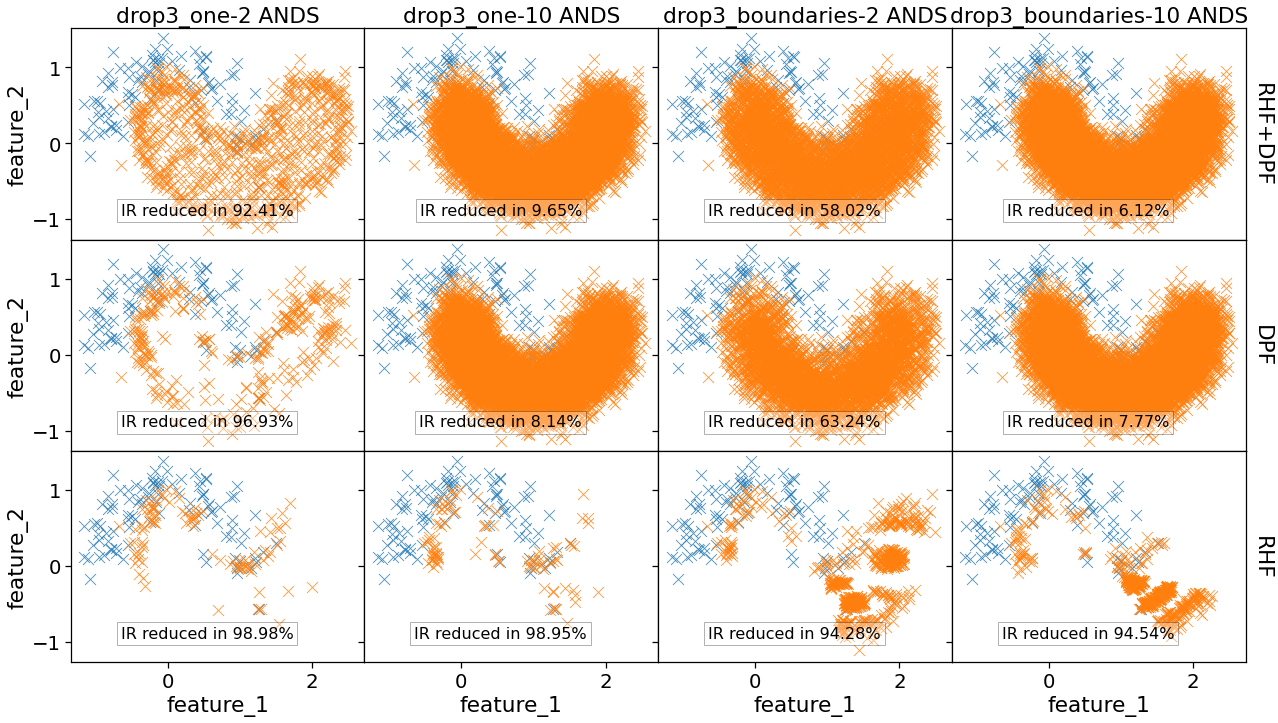

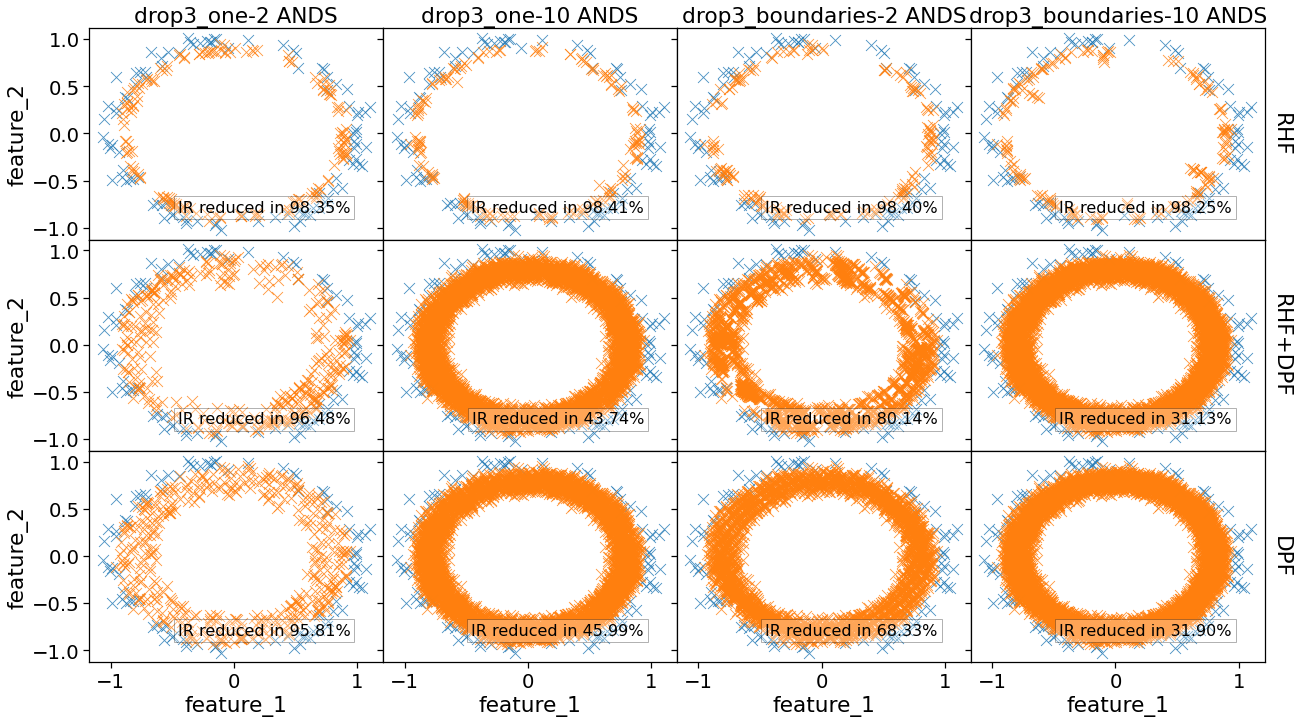

In [55]:
col_order = ["drop3_one-2 ANDS", "drop3_one-10 ANDS",
            "drop3_boundaries-2 ANDS", "drop3_boundaries-10 ANDS"]

ir_dif_1 = plot_example(['dummy_data_v3'], [c for c in results.is_ands.unique() if 'entropy' not in c], 'drop3_1')
ir_dif_2 = plot_example(['dummy_data_v2'], [c for c in results.is_ands.unique() if 'entropy' not in c], 'drop3_2')

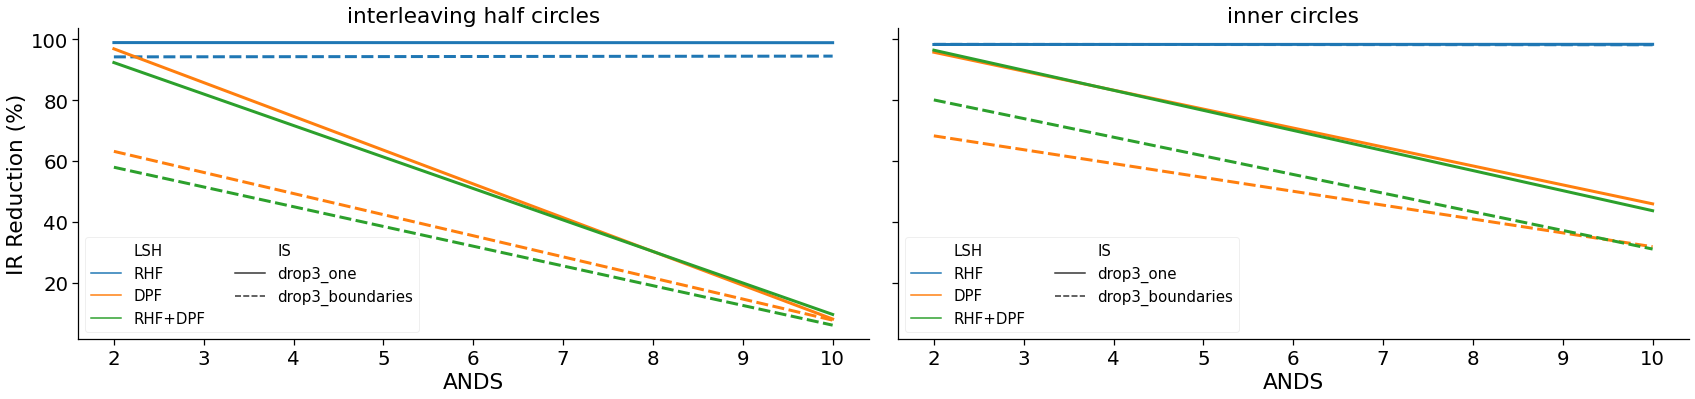

In [57]:
ir_dif_1['dataset'] = 'interleaving half circles'
ir_dif_2['dataset'] = 'inner circles'
ir_df = pd.concat([ir_dif_1,ir_dif_2], ignore_index=True)

ir_df['ANDS'] = ir_df['is'].str.split("-").apply(lambda x : int(x[-1].split("ANDS")[0]))
ir_df['IS'] = ir_df['is'].str.split("-").apply(lambda x : x[0])
ir_df['IR'] = pd.to_numeric(ir_df['ir'])
ir_df['IR Reduction (%)'] = (1 - ir_df['IR']/100.0)*100.0 
sns.color_palette("bright")
#sns.relplot(data = ir_df, x='ANDS', hue= 'method', y = 'IR', kind = 'line', row= 'dataset', aspect=1, height=5)
g = sns.FacetGrid(data = ir_df,
                  col = 'dataset',
                  margin_titles = True, legend_out = True, 
                  despine=True, aspect=2, height=6)

g.map_dataframe(sns.lineplot, hue = 'LSH',
             hue_order = hue_order,
            x='ANDS', style = 'IS',
            y='IR Reduction (%)', linewidth = 3), 
g.set_titles(col_template="{col_name}")
g.set_xlabels("ANDS")
for ax in g.axes.ravel():
    ax.legend(fontsize = 'x-small', framealpha= 0.3,ncol = 2)


plt.savefig(f'report/drop3_ir.png', dpi = 300)